In [1]:
!pip install git+https://github.com/fastai/fastai.git &> /dev/null

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd

path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names=['user', 'movie', 'rating', 'timestamp'])
movies = pd.read_csv(
    path/'u.item', delimiter='|', encoding='latin-1',
    usecols=(0, 1), names=('movie', 'title'), header=None)
ratings = ratings.merge(movies)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
    
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)

        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)
    
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.947165,0.930747,00:09
1,0.823398,0.861059,00:07
2,0.602876,0.860865,00:07
3,0.393528,0.884714,00:07
4,0.275008,0.891144,00:07


## 00:00:00 - Weight decay

* Issue from last lesson: loss started to go down then up again.
  * We're overfitting.
* Note that we don't need a metric because mean-squared error is close enough to what we care about.
* We reduce overfitting by reducing the capacity of the model
  * Ensure it doesn't memorise the dataset.
  * Reducing params does bias model towards simple shapes.
* Instead, force params to be smaller, unless they need to be big.
* Weight decay, also known as L2 regularisation, adds the sum of all params squared to loss.
  * Tries to encourage weights to be as small as possible: loss function is incentivised to keep weights small.
* Can simply add the weights to the loss function:
```
loss_with_wd = loss + wd * (parameters ** 2).sum()
```

* Since the loss function is used to take the gradient, and we know the derivative of `p**2` with respect to `p` is `2*p`, we can just update the gradients:

```
weight.grad += wd * 2 * weight
```

* In fastai, you can just pass `wd` amount to the fit call:

In [3]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.952407,0.954321,00:07
1,0.845610,0.875941,00:07
2,0.737699,0.834738,00:08
3,0.594368,0.819223,00:07
4,0.481654,0.820020,00:07


* Modern deep learning we prefer weight decay vs simplier models.

## 00:07:10 - Writing our own embedddings layer

* To create our own layer, it needs to inherit from `nn.Module`
* We can get a list of parameters using the `parameters()` method.
  * To ensure something in a module needs to be learned, you wrap in `nn.Parameter`

In [4]:
class T(Module):
    def __init__(self):
        self.a = nn.Parameter(torch.ones(3))
        
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

* Create a randomly initialised tensor as param:

In [5]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [6]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
    
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])

        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users * movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [7]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929160,0.947257,00:06
1,0.821899,0.868087,00:06
2,0.718155,0.830080,00:07
3,0.581698,0.820761,00:07
4,0.469228,0.822052,00:07


## 00:12:31 - Interpreting embeddings and biases

* You can call `learn.model` to get model in learner.
* We can interpret bias initially.
* Start by printing movie with smallest bias.

In [8]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:15]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Big Bully (1996)',
 'Mortal Kombat: Annihilation (1997)',
 '3 Ninjas: High Noon At Mega Mountain (1998)',
 'Bio-Dome (1996)',
 'Grease 2 (1982)',
 'Robocop 3 (1993)',
 'Leave It to Beaver (1997)',
 'Island of Dr. Moreau, The (1996)',
 'Hellraiser: Bloodline (1996)',
 'Bad Girls (1994)',
 'Tales from the Crypt Presents: Bordello of Blood (1996)',
 'Ed (1996)',
 'Amityville: A New Generation (1993)']

* These are the movies that people liked the least. Even people that like this genre didn't like the movie.
* Can do the opposite:

In [9]:
idxs = movie_bias.argsort(descending=True)[:15]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'As Good As It Gets (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Star Wars (1977)',
 'Silence of the Lambs, The (1991)',
 'Apt Pupil (1998)',
 'Close Shave, A (1995)',
 'Good Will Hunting (1997)',
 'Wrong Trousers, The (1993)',
 'L.A. Confidential (1997)',
 'To Kill a Mockingbird (1962)',
 'Rear Window (1954)',
 'Fugitive, The (1993)']

* Even people who don't like the genre still liked the movie, generally.

* Can also use PCA analysis to reduce factors down to 2. Which lets us plot them:

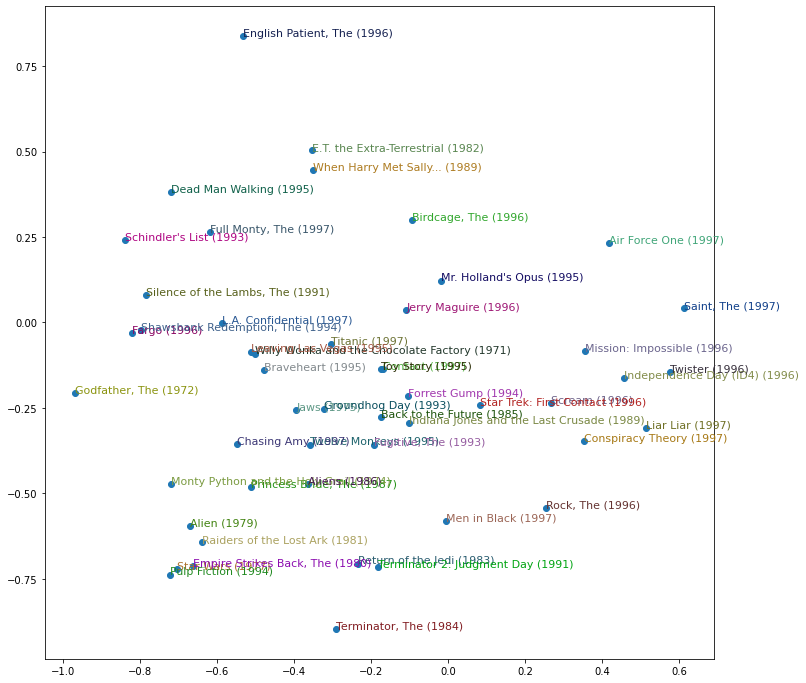

In [10]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3) * 0.7, fontsize=11)
plt.show()

* Can see that there's different clusters of movies.

## 00:16:20 - Using `collab_learner`

* `collab_learner` wraps up all the functionality above in a single function.

In [11]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.913675,0.951781,00:08
1,0.838763,0.877814,00:07
2,0.716968,0.835209,00:09
3,0.586227,0.820372,00:07
4,0.496024,0.820858,00:09


* Can see the names of layers by printing model:

In [12]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

## 00:17:37 - Embedding distance

* Can calculate the distance between 2 coordinates using cosign similarity.
* Then, find the movies that are most similar to another movie:

In [13]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Godfather, The (1972)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[:5]
dls.classes['title'][idx]

(#5) ['Godfather, The (1972)','Godfather: Part II, The (1974)','When We Were Kings (1996)','Bonnie and Clyde (1967)','Lawrence of Arabia (1962)']

## 00:19:53 - Collab filtering with NN

* Could put item and movie factors into a tensor, then feed into neural network.
* fastai has a function `get_emb_sz` that gives you recommended sizes for your data:

In [14]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [15]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [16]:
model = CollabNN(*embs)

In [17]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.981711,0.950668,00:08
1,0.887367,0.910555,00:09
2,0.877503,0.883071,00:08
3,0.866312,0.865463,00:08
4,0.796303,0.867357,00:08


* Though model isn't as good, it does allow us flexibility to have different embedding sizes for movies or user.
* Same can be achieved with `collab_learner` function using `use_nn=True` argument:

In [18]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100, 50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.985896,0.977544,00:10
1,0.905485,0.937513,00:10
2,0.851978,0.888632,00:10
3,0.826538,0.864366,00:10
4,0.771533,0.863534,00:10


* The `EmbeddingNN` model used in collab_learner is only 1 line of code, as it inherits from `TabularModel`